In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler

In [6]:
from sklearn.metrics import roc_curve, auc

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
import string
import warnings
warnings.filterwarnings('ignore')


In [9]:
df_train=pd.read_csv('train.csv', index_col='PassengerId')

In [10]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df_test=pd.read_csv('test.csv', index_col='PassengerId')

In [12]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
df_all=pd.concat([df_train, df_test])

In [14]:
df_train.shape

(891, 11)

In [15]:
df_test.shape

(418, 10)

In [16]:
df_all.shape

(1309, 11)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [18]:
df_train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [19]:
df_test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [20]:
df_all.corr()

,Age,Fare,Parch,Pclass,SibSp,Survived
Age,1.000000,0.178740,-0.150917,-0.408106,-0.243699,-0.077221
Fare,0.178740,1.000000,0.221539,-0.558629,0.160238,0.257307
Parch,-0.150917,0.221539,1.000000,0.018322,0.373587,0.081629
Pclass,-0.408106,-0.558629,0.018322,1.000000,0.060832,-0.338481
SibSp,-0.243699,0.160238,0.373587,0.060832,1.000000,-0.035322
Survived,-0.077221,0.257307,0.081629,-0.338481,-0.035322,1.000000


In [21]:
age_by_pclass_sex=df_all.groupby(['Sex','Pclass']).median()['Age']

In [22]:
age_by_pclass_sex

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [23]:
df_all['Age']=df_all.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

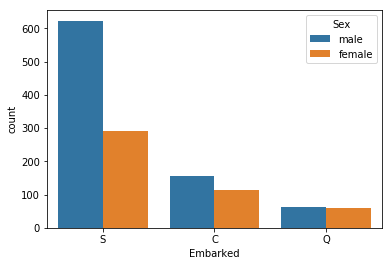

In [24]:
sns.countplot('Embarked',data=df_all, hue="Sex")

In [25]:
df_all['Embarked']=df_all['Embarked'].fillna('S')

In [26]:
df_all[df_all['Fare'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701


In [27]:
med_fare=df_all.groupby(['Pclass','Parch','SibSp']).median()['Fare'][3][0][0]

In [28]:
df_all['Fare']=df_all['Fare'].fillna(med_fare)

In [29]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [30]:
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [31]:
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count()

In [32]:
df_all_decks

Age  Cabin  Embarked  Fare  Name  Parch  Sex  SibSp  Survived  \
Deck Pclass                                                                  
A    1        23     23        23    23    23     23   23     23        16   
B    1        65     65        65    65    65     65   65     65        47   
C    1        94     94        94    94    94     94   94     94        59   
D    1        40     40        40    40    40     40   40     40        29   
     2         6      6         6     6     6      6    6      6         4   
E    1        34     34        34    34    34     34   34     34        25   
     2         4      4         4     4     4      4    4      4         4   
     3         3      3         3     3     3      3    3      3         3   
F    2        13     13        13    13    13     13   13     13         8   
     3         8      8         8     8     8      8    8      8         5   
G    3         5      5         5     5     5      5    5      5         4   
M    1        67      0        67    67    67     67   67     67        40   
     2       254      0       254   254   254    254  254    254       168   
     3       693      0       693   693   693    693  693    693       479   

             Ticket  
Deck Pclass          
A    1           23  
B    1           65  
C    1           94  
D    1           40  
     2            6  
E    1           34  
     2            4  
     3            3  
F    2           13  
     3            8  
G    3            5  
M    1           67  
     2          254  
     3          693

In [33]:
df_all_decks1 = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

In [34]:
df_all_decks1

Deck     A   B   C   D      E         F     G   M          
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3
Count   23  65  94  40  6  34  4  3  13  8  5  67  254  693

In [35]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count()

In [36]:
df_all_decks_survived

Age  Cabin  Embarked  Fare  Name  Parch  Pclass  Sex  SibSp  \
Deck Survived                                                                
A    0.0         9      9         9     9     9      9       9    9      9   
     1.0         7      7         7     7     7      7       7    7      7   
B    0.0        12     12        12    12    12     12      12   12     12   
     1.0        35     35        35    35    35     35      35   35     35   
C    0.0        24     24        24    24    24     24      24   24     24   
     1.0        35     35        35    35    35     35      35   35     35   
D    0.0         8      8         8     8     8      8       8    8      8   
     1.0        25     25        25    25    25     25      25   25     25   
E    0.0         8      8         8     8     8      8       8    8      8   
     1.0        24     24        24    24    24     24      24   24     24   
F    0.0         5      5         5     5     5      5       5    5      5   
     1.0         8      8         8     8     8      8       8    8      8   
G    0.0         2      2         2     2     2      2       2    2      2   
     1.0         2      2         2     2     2      2       2    2      2   
M    0.0       481      0       481   481   481    481     481  481    481   
     1.0       206      0       206   206   206    206     206  206    206   

               Ticket  
Deck Survived          
A    0.0            9  
     1.0            7  
B    0.0           12  
     1.0           35  
C    0.0           24  
     1.0           35  
D    0.0            8  
     1.0           25  
E    0.0            8  
     1.0           24  
F    0.0            5  
     1.0            8  
G    0.0            2  
     1.0            2  
M    0.0          481  
     1.0          206

In [37]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [38]:
df_all.drop(['Cabin'], inplace=True,axis=1)

In [39]:
df_train=df_all.iloc[0:891,:]

In [40]:
df_train.shape

(891, 11)

In [41]:
df_test=df_all.iloc[891:,:]

In [42]:
df_test.shape

(418, 11)

In [43]:
df_train.isna().sum()

Age         0
Embarked    0
Fare        0
Name        0
Parch       0
Pclass      0
Sex         0
SibSp       0
Survived    0
Ticket      0
Deck        0
dtype: int64

In [44]:
df_test.isna().sum()

Age           0
Embarked      0
Fare          0
Name          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
Ticket        0
Deck          0
dtype: int64

In [45]:
df_test.drop('Survived', axis=1, inplace=True)

In [46]:
df_test.isna().sum()

Age         0
Embarked    0
Fare        0
Name        0
Parch       0
Pclass      0
Sex         0
SibSp       0
Ticket      0
Deck        0
dtype: int64

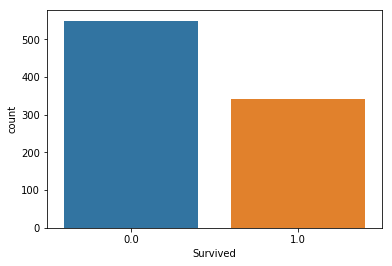

In [47]:
sns.countplot('Survived', data=df_all)

In [48]:
df_all.corr()

,Age,Fare,Parch,Pclass,SibSp,Survived
Age,1.000000,0.198704,-0.134239,-0.451983,-0.204025,-0.058635
Fare,0.198704,1.000000,0.221669,-0.558742,0.160389,0.257307
Parch,-0.134239,0.221669,1.000000,0.018322,0.373587,0.081629
Pclass,-0.451983,-0.558742,0.018322,1.000000,0.060832,-0.338481
SibSp,-0.204025,0.160389,0.373587,0.060832,1.000000,-0.035322
Survived,-0.058635,0.257307,0.081629,-0.338481,-0.035322,1.000000


In [49]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

In [50]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

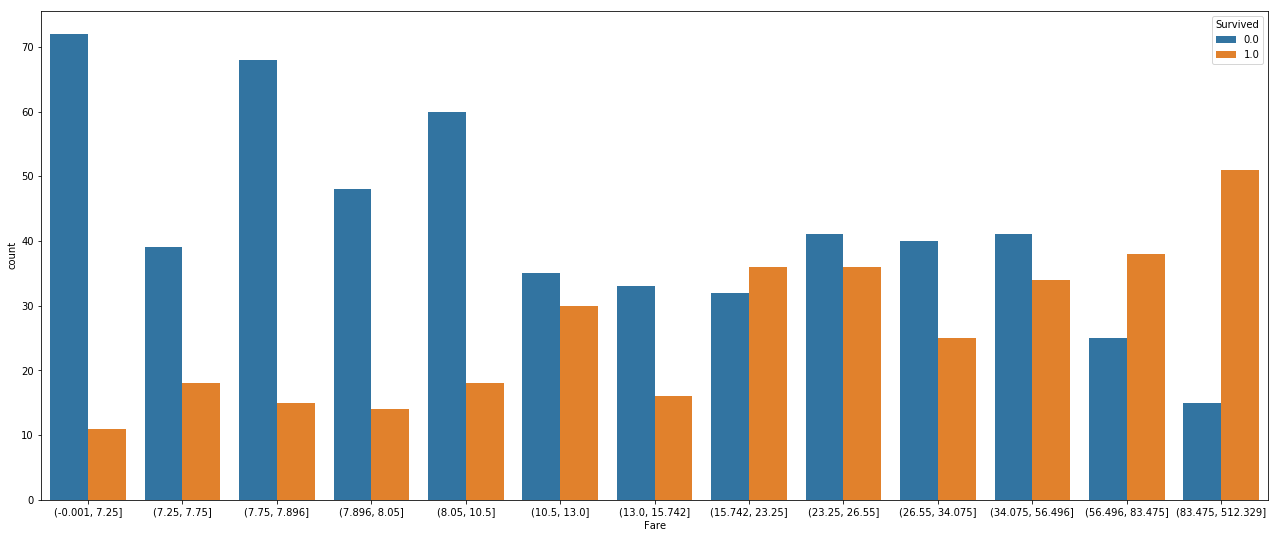

In [51]:
plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

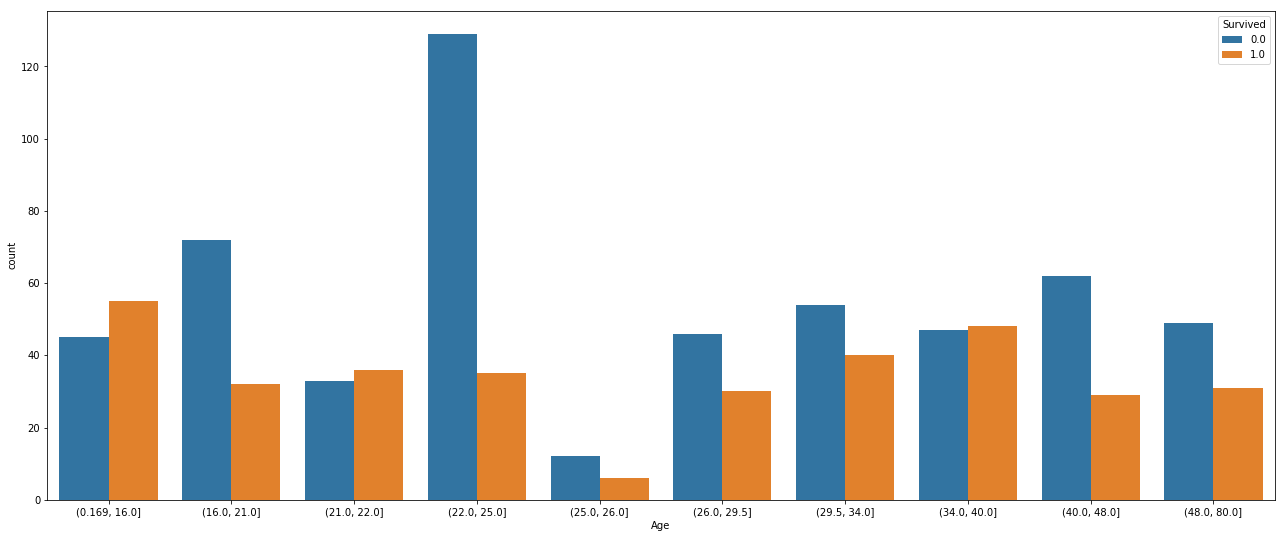

In [52]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

In [53]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [54]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

In [55]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [56]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [57]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Deck,Family_Size,Family_Size_Grouped,Title
PassengerId,,,,,,,,,,,,,,
1,"(21.0, 22.0]",S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,M,2,Small,Mr
2,"(34.0, 40.0]",C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,ABC,2,Small,Miss/Mrs/Ms
3,"(25.0, 26.0]",S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,M,1,Alone,Miss/Mrs/Ms
4,"(34.0, 40.0]",S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,ABC,2,Small,Miss/Mrs/Ms
5,"(34.0, 40.0]",S,"(7.896, 8.05]","Allen, Mr. William Henry",0,3,male,0,0.0,373450,M,1,Alone,Mr


In [58]:
df_all=df_all.drop(['Name','Ticket','Parch','SibSp','Family_Size'], axis=1)

In [59]:
df_all.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Deck,Family_Size_Grouped,Title
PassengerId,,,,,,,,,
1,"(21.0, 22.0]",S,"(-0.001, 7.25]",3,male,0.0,M,Small,Mr
2,"(34.0, 40.0]",C,"(56.496, 83.475]",1,female,1.0,ABC,Small,Miss/Mrs/Ms
3,"(25.0, 26.0]",S,"(7.896, 8.05]",3,female,1.0,M,Alone,Miss/Mrs/Ms
4,"(34.0, 40.0]",S,"(34.075, 56.496]",1,female,1.0,ABC,Small,Miss/Mrs/Ms
5,"(34.0, 40.0]",S,"(7.896, 8.05]",3,male,0.0,M,Alone,Mr


In [60]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']


for feature in non_numeric_features:        
    df_all[feature] = LabelEncoder().fit_transform(df_all[feature])

In [61]:
df_all.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Deck,Family_Size_Grouped,Title
PassengerId,,,,,,,,,
1,2,2,0,3,1,0.0,3,3,3
2,7,0,11,1,0,1.0,0,3,2
3,4,2,3,3,0,1.0,3,0,2
4,7,2,10,1,0,1.0,0,3,2
5,7,2,3,3,1,0.0,3,0,3


In [62]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']

In [63]:
df_all_cat=df_all[['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']]

In [64]:
df_all_remain=df_all[['Age','Fare']]

In [65]:
one_hot_cols = df_all_cat.columns.tolist()
df_all_cat = pd.get_dummies(df_all_cat, columns=one_hot_cols)

df_all_cat.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Deck_0,Deck_1,Deck_2,Deck_3,Embarked_0,Embarked_1,Embarked_2,Title_0,Title_1,Title_2,Title_3,Family_Size_Grouped_0,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0
4,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
5,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0


In [66]:
df_all=pd.concat([df_all_cat,df_all_remain],axis=1)

In [67]:
df_all.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Deck_0,Deck_1,Deck_2,Deck_3,Embarked_0,...,Title_0,Title_1,Title_2,Title_3,Family_Size_Grouped_0,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Age,Fare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,2,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,7,11
3,0,0,1,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,4,3
4,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,7,10
5,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,7,3


In [68]:
df_train1=df_all.iloc[0:891,:]

In [69]:
df_train1.shape

(891, 22)

In [70]:
df_test1=df_all.iloc[891:,:]

In [71]:
df_test1.shape

(418, 22)

In [72]:
y=df_train['Survived']

In [73]:
sc=StandardScaler()

In [74]:
X_train = sc.fit_transform(df_train1)

In [75]:
X_test = sc.transform(df_test1)

In [99]:
from sklearn.model_selection import GridSearchCV
parameters=[{'random_state':[42],'min_samples_split':[6,7], 'min_samples_leaf':[6,7], 'n_estimators':[100,1500,2000],'criterion':['gini','entropy'], 'max_features':['auto'], 'max_depth':[5,10,15]}]
grid_search=GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10)
grid_search=grid_search.fit(X_train, y)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | e

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:  

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed

[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | 

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      |

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapse

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:  

[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elaps

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   

[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks  

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel

[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elaps

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | e

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:  

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      |

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      |

[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks  

[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapse

In [100]:
grid_search.best_score_

0.8305274971941639

In [195]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 42, criterion='gini', max_depth=5,min_samples_leaf = 6, min_samples_split= 6,  max_features='auto', n_estimators=900)
"""
#classifier = RandomForestClassifier(criterion='gini',
#                                           n_estimators=1750,
#                                           max_depth=7,
#                                           min_samples_split=6,
#                                           min_samples_leaf=6,
#                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)
"""                                           
classifier.fit(X_train, y)
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=classifier, X=X_train,scoring='accuracy', y=y, cv=5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [196]:
y_pred = classifier.predict(X_test)

In [194]:
accuracies.mean()

0.8327301100896607

In [198]:
y_pred=pd.DataFrame(y_pred)

In [199]:
y_pred.to_csv('y_pred_RandomForest_GridSearch3.csv')